# 경로가 휘는 문제 발생

In [22]:
#!/usr/bin/env python3

# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.

# Author: Ryan De Iaco
# Additional Comments: Carlos Wang
# Date: October 29, 2018

import numpy as np
import scipy.optimize
import scipy.integrate
from math import sin, cos, pi, sqrt

class PathOptimizer:
    def __init__(self):
        self._xf = 0.0
        self._yf = 0.0
        self._tf = 0.0

    ######################################################
    ######################################################
    # MODULE 7: PARAMETER OPTIMIZATION FOR POLYNOMIAL SPIRAL
    #   Read over the function comments to familiarize yourself with the
    #   arguments and necessary variables to return. Then follow the TODOs
    #   (top-down) and use the surrounding comments as a guide.
    ######################################################
    ######################################################
    # Sets up the optimization problem to compute a spiral to a given
    # goal point, (xf, yf, tf).
    def optimize_spiral(self, xf, yf, tf):
        """Optimization function used for finding the optimization parameters.

        Assumptions:
            1. The first point in the spiral is in origin of the vehicle frame
            2. Assumes that the curvature for the endpoints to be zero
               (i.e. p0 and p3 are zero of the vector p = [p0, p1, p2, p3, sf])

        args:
            xf: Final x position (m) for the given goal state.
            yf: Final y position (m) for the given goal state.
            tf: Final yaw position (rad) for the given goal state.

        returns:
            spiral: The resulting optimized path that best fits the goal state.
                The path is a list of points of the following format:
                    [x_points, y_points, t_points]:
                        x_points: List of x values (m) along the spiral
                        y_points: List of y values (m) along the spiral
                        z_points: List of yaw values (rad) along the spiral
        """
        # Save the terminal x, y, and theta.
        self._xf = xf
        self._yf = yf
        self._tf = tf
        # The straight line distance serves as a lower bound on any path's
        # arc length to the goal.
        sf_0 = np.linalg.norm([xf, yf])
        # The initial variables correspond to a straight line with arc length
        # sf_0.  Recall that p here is defined as:
        #    [p1, p2, sf]
        #, where p1 and p2 are the curvatures at points p1 and p2
        #, and sf is the final arc length for the spiral.
        # Since we already set p0 and p4 (being the curvature of
        # the initial and final points) to be zero.
        p0 = [0.0, 0.0, sf_0]

        # Here we will set the bounds [lower, upper] for each optimization 
        # variable.
        # The first two variables correspond to the curvature 1/3rd of the
        # way along the path and 2/3rds of the way along the path, respectively.
        # As a result, their curvature needs to lie within [-0.5, 0.5].
        # The third variable is the arc length, it has no upper limit, and it
        # has a lower limit of the straight line arc length.
        # TODO: INSERT YOUR CODE BETWEEN THE DASHED LINES
        # ------------------------------------------------------------------
        bounds = [[-0.5, 0.5], [-0.5, 0.5], [sf_0, np.inf]]
        # ------------------------------------------------------------------

        # Here we will call scipy.optimize.minimize to optimize our spiral.
        # The objective and gradient are given to you by self.objective, and
        # self.objective_grad. The bounds are computed above, and the inital
        # variables for the optimizer are set by p0. You should use the L-BFGS-B
        # optimization methods.
        # TODO: INSERT YOUR CODE BETWEEN THE DASHED LINES
        # ------------------------------------------------------------------
        res = scipy.optimize.minimize(
            self.objective, p0, method='L-BFGS-B', jac=self.objective_grad, constraints=bounds
        )
        # ------------------------------------------------------------------

        spiral = self.sample_spiral(res.x)
        return spiral

    ######################################################
    ######################################################
    # MODULE 7: COMPUTE LIST OF THETAS
    #   Read over the function comments to familiarize yourself with the
    #   arguments and necessary variables to return. Then follow the TODOs
    #   (top-down) and use the surrounding comments as a guide.
    ######################################################
    ######################################################
    # This function computes the theta values for a given list of
    # arc lengths, and spiral parameters a, b, c, d.
    # Recall that the equation of a cubic spiral is
    # kappa(s) = a + b*s + c*s^2 + d*s^3
    # and since theta(s) is the integral of kappa(s) with respect to
    # arc length, then theta(s) = a*s + b/2*s^2 + c/3*s^3 + d/4*s^4.
    # Try to vectorize this function using numpy for speed, if you can.
    # Inputs: a - the first term of kappa(s).
    #         b - the second term of kappa(s).
    #         c - the third term of kappa(s).
    #         d - the fourth term of kappa(s).
    def thetaf(self, a, b, c, d, s):
        # TODO: INSERT YOUR CODE BETWEEN THE DASHED LINES
        # ------------------------------------------------------------------
        # # Remember that a, b, c, d and s are lists
        # ...
        thetas = [a * x + b * x**2 / 2 + c * x**3 / 3 + d * x**4 / 4 for x in s]
        return thetas
        # ------------------------------------------------------------------

    ######################################################
    ######################################################
    # MODULE 7: SAMPLE SPIRAL PATH
    #   Read over the function comments to familiarize yourself with the
    #   arguments and necessary variables to return. Then follow the TODOs
    #   (top-down) and use the surrounding comments as a guide.
    ######################################################
    ######################################################
    # This function samples the spiral along its arc length to generate
    # a discrete set of x, y, and theta points for a path.
    def sample_spiral(self, p):
        """Samples a set of points along the spiral given the optimization
        parameters.

        args:
            p: The resulting optimization parameters that minimizes the
                objective function given a goal state.
                Format: [p1, p2, sf], Unit: [1/m, 1/m, m]
                , where p1 and p2 are the curvatures at points p1 and p2
                  and sf is the final arc length for the spiral.
        returns:
            [x_points, y_points, t_points]:
                x_points: List of x values (m) along the spiral
                y_points: List of y values (m) along the spiral
                t_points: List of yaw values (rad) along the spiral
        """
        # These equations map from the optimization parameter space
        # to the spiral parameter space.   
        p = [0.0, p[0], p[1], 0.0, p[2]]    # recall p0 and p3 are set to 0
                                            # and p4 is the final arc length
        a = p[0]
        b = -(11.0*p[0]/2.0 - 9.0*p[1] + 9.0*p[2]/2.0 - p[3])/p[4]
        c = (9.0*p[0] - 45.0*p[1]/2.0 + 18.0*p[2] - 9.0*p[3]/2.0)/p[4]**2
        d = -(9.0*p[0]/2.0 - 27.0*p[1]/2.0 + 27.0*p[2]/2.0 - 9.0*p[3]/2.0)/p[4]**3


        # Set the s_points (list of s values along the spiral) to be from 0.0
        # to p[4] (final arc length)
        s_points = np.linspace(0.0, p[4])

        # Compute the theta, x, and y points from the uniformly sampled
        # arc length points s_points (p[4] is the spiral arc length).
        # Use self.thetaf() to compute the theta values from the s values.
        # Recall that x = integral cos(theta(s)) ds and
        #             y = integral sin(theta(s)) ds.
        # You will find the scipy.integrate.cumtrapz() function useful.
        # Try to vectorize the code using numpy functions for speed if you can.

        # Try to vectorize the code using numpy functions for speed if you can.
        # TODO: INSERT YOUR CODE BETWEEN THE DASHED LINES
        # ------------------------------------------------------------------
        t_points = self.thetaf(a, b, c, d, s_points)
        x_points = scipy.integrate.cumtrapz(np.cos(t_points), s_points, initial=0.0)
        y_points = scipy.integrate.cumtrapz(np.sin(t_points), s_points, initial=0.0)
        return [x_points, y_points, t_points]
        # ------------------------------------------------------------------

    ######################################################
    ######################################################
    # BELOW ARE THE FUNCTIONS USED FOR THE OPTIMIZER.
    ######################################################
    ######################################################

    def objective(self, p):
        """
        The optimizer can freely move 3 of the spiral parameter variables.
        The other two are fixed due to boundary conditions.
        """
        p = [0.0, p[0], p[1], 0.0, p[2]]
        return self.fbe(p) + 25*(self.fxf(p) + self.fyf(p)) + 30*self.ftf(p)

    def objective_grad(self, p):
        """
        The optimizer can freely move 3 of the spiral parameter variables.
        The other two are fixed due to boundary conditions.
        """
        p = [0.0, p[0], p[1], 0.0, p[2]]
        return np.add(np.add(np.add(self.fbe_grad(p), np.multiply(25, self.fxf_grad(p))), \
            np.multiply(25, self.fyf_grad(p))), np.multiply(30, self.ftf_grad(p)))

    def fxf(self, p):
        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = self._xf-p[4]*(cos(p[0]*p[4]-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*t14*(1.0/2.0))+cos(p[0]*p[4]*(1.0/2.0)-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1)+p[4]*t14*(1.0/8.0))*2.0+cos(p[0]*p[4]*(3.0/4.0)-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*t14*(9.0/3.2E1))*2.0+cos(p[0]*p[4]*(1.0/4.0)-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2)+p[4]*t14*(1.0/3.2E1))*2.0+cos(p[0]*p[4]*(3.0/8.0)-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2)+p[4]*t14*(9.0/1.28E2))*4.0+cos(p[0]*p[4]*(1.0/8.0)-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4+p[4]*t14*(1.0/1.28E2))*4.0+cos(p[0]*p[4]*(5.0/8.0)-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*t14*(2.5E1/1.28E2))*4.0+cos(p[0]*p[4]*(7.0/8.0)-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*t14*(4.9E1/1.28E2))*4.0+1.0)*(1.0/2.4E1);
        t0 = t15*t15;
        return t0

    def fxf_grad(self, p):
        grad = [0.0, 0.0, 0.0]

        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[0]*p[4]*(3.0/4.0);
        t18 = p[0]*p[4]*(1.0/4.0);
        t19 = p[0]*p[4]*(3.0/8.0);
        t20 = p[0]*p[4]*(1.0/8.0);
        t21 = p[0]*p[4]*(5.0/8.0);
        t22 = p[0]*p[4]*(7.0/8.0);
        t0 = p[4]*(self._xf-p[4]*(cos(t15-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*t14*(1.0/2.0))+cos(t16-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1)+p[4]*t14*(1.0/8.0))*2.0+cos(t17-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*t14*(9.0/3.2E1))*2.0+cos(t18-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2)+p[4]*t14*(1.0/3.2E1))*2.0+cos(t19-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2)+p[4]*t14*(9.0/1.28E2))*4.0+cos(t20-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4+p[4]*t14*(1.0/1.28E2))*4.0+cos(t21-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*t14*(2.5E1/1.28E2))*4.0+cos(t22-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*t14*(4.9E1/1.28E2))*4.0+1.0)*(1.0/2.4E1))*(p[4]*sin(t15-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*(p[3]-t2+t3-t4)*(1.0/2.0))*(3.0/8.0)+p[4]*sin(t16-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1)+p[4]*(p[3]-t2+t3-t4)*(1.0/8.0))*(5.1E1/6.4E1)+p[4]*sin(t17-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*(p[3]-t2+t3-t4)*(9.0/3.2E1))*8.701171875E-1+p[4]*sin(t18-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2)+p[4]*(p[3]-t2+t3-t4)*(1.0/3.2E1))*3.544921875E-1+p[4]*sin(t19-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2)+p[4]*(p[3]-t2+t3-t4)*(9.0/1.28E2))*1.2161865234375+p[4]*sin(t20-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4+p[4]*(p[3]-t2+t3-t4)*(1.0/1.28E2))*2.259521484375E-1+p[4]*sin(t21-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*(p[3]-t2+t3-t4)*(2.5E1/1.28E2))*1.7669677734375+p[4]*sin(t22-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*(p[3]-t2+t3-t4)*(4.9E1/1.28E2))*1.5970458984375)*(1.0/1.2E1);
        grad[0] = t0

        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[4]*t14*(1.0/8.0);
        t18 = t16+t17-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1);
        t19 = p[0]*p[4]*(3.0/4.0);
        t20 = p[0]*p[4]*(1.0/4.0);
        t21 = p[4]*t14*(1.0/3.2E1);
        t22 = t20+t21-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2);
        t23 = p[0]*p[4]*(3.0/8.0);
        t24 = p[4]*t14*(9.0/1.28E2);
        t25 = t23+t24-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2);
        t26 = p[0]*p[4]*(1.0/8.0);
        t27 = p[4]*t14*(1.0/1.28E2);
        t28 = t26+t27-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4;
        t29 = p[0]*p[4]*(5.0/8.0);
        t30 = p[0]*p[4]*(7.0/8.0);
        t0 = p[4]*(self._xf-p[4]*(cos(t15-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*t14*(1.0/2.0))+cos(t19-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*t14*(9.0/3.2E1))*2.0+cos(t29-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*t14*(2.5E1/1.28E2))*4.0+cos(t30-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*t14*(4.9E1/1.28E2))*4.0+cos(t18)*2.0+cos(t22)*2.0+cos(t25)*4.0+cos(t28)*4.0+1.0)*(1.0/2.4E1))*(p[4]*sin(t15-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*(p[3]-t2+t3-t4)*(1.0/2.0))*(3.0/8.0)+p[4]*sin(t19-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*(p[3]-t2+t3-t4)*(9.0/3.2E1))*3.955078125E-1+p[4]*sin(t29-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*(p[3]-t2+t3-t4)*(2.5E1/1.28E2))*2.838134765625E-1+p[4]*sin(t30-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*(p[3]-t2+t3-t4)*(4.9E1/1.28E2))*1.2740478515625-p[4]*sin(t18)*(3.0/6.4E1)-p[4]*sin(t22)*1.201171875E-1-p[4]*sin(t25)*2.669677734375E-1-p[4]*sin(t28)*9.70458984375E-2)*(1.0/1.2E1);
        grad[1] = t0

        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[0]*p[4]*(3.0/4.0);
        t18 = p[0]*p[4]*(1.0/4.0);
        t19 = p[0]*p[4]*(3.0/8.0);
        t20 = p[0]*p[4]*(1.0/8.0);
        t21 = p[0]*p[4]*(5.0/8.0);
        t22 = p[0]*p[4]*(7.0/8.0);
        t23 = p[4]*(p[3]-t2+t3-t4)*(1.0/2.0);
        t39 = p[4]*t9*(1.0/4.0);
        t40 = p[4]*t13*(1.0/3.0);
        t24 = t15+t23-t39-t40;
        t25 = p[4]*(p[3]-t2+t3-t4)*(1.0/8.0);
        t41 = p[4]*t9*(1.0/6.4E1);
        t42 = p[4]*t13*(1.0/2.4E1);
        t26 = t16+t25-t41-t42;
        t27 = p[4]*(p[3]-t2+t3-t4)*(1.0/3.2E1);
        t45 = p[4]*t9*9.765625E-4;
        t46 = p[4]*t13*(1.0/1.92E2);
        t28 = t18+t27-t45-t46;
        t29 = p[4]*(p[3]-t2+t3-t4)*(9.0/3.2E1);
        t43 = p[4]*t9*7.91015625E-2;
        t44 = p[4]*t13*(9.0/6.4E1);
        t30 = t17+t29-t43-t44;
        t31 = p[4]*(p[3]-t2+t3-t4)*(1.0/1.28E2);
        t49 = p[4]*t9*6.103515625E-5;
        t50 = p[4]*t13*6.510416666666667E-4;
        t32 = t20+t31-t49-t50;
        t33 = p[4]*(p[3]-t2+t3-t4)*(9.0/1.28E2);
        t47 = p[4]*t9*4.94384765625E-3;
        t48 = p[4]*t13*(9.0/5.12E2);
        t34 = t19+t33-t47-t48;
        t35 = p[4]*(p[3]-t2+t3-t4)*(2.5E1/1.28E2);
        t51 = p[4]*t9*3.814697265625E-2;
        t52 = p[4]*t13*8.138020833333333E-2;
        t36 = t21+t35-t51-t52;
        t37 = p[4]*(p[3]-t2+t3-t4)*(4.9E1/1.28E2);
        t53 = p[4]*t9*1.4654541015625E-1;
        t54 = p[4]*t13*2.233072916666667E-1;
        t38 = t22+t37-t53-t54;
        t0 = (self._xf-p[4]*(cos(t15-t39-t40+p[4]*t14*(1.0/2.0))+cos(t16-t41-t42+p[4]*t14*(1.0/8.0))*2.0+cos(t18-t45-t46+p[4]*t14*(1.0/3.2E1))*2.0+cos(t17-t43-t44+p[4]*t14*(9.0/3.2E1))*2.0+cos(t20-t49-t50+p[4]*t14*(1.0/1.28E2))*4.0+cos(t19-t47-t48+p[4]*t14*(9.0/1.28E2))*4.0+cos(t21-t51-t52+p[4]*t14*(2.5E1/1.28E2))*4.0+cos(t22-t53-t54+p[4]*t14*(4.9E1/1.28E2))*4.0+1.0)*(1.0/2.4E1))*(cos(t24)*(1.0/2.4E1)+cos(t26)*(1.0/1.2E1)+cos(t28)*(1.0/1.2E1)+cos(t30)*(1.0/1.2E1)+cos(t32)*(1.0/6.0)+cos(t34)*(1.0/6.0)+cos(t36)*(1.0/6.0)+cos(t38)*(1.0/6.0)-p[4]*(sin(t24)*(p[0]*(1.0/8.0)+p[1]*(3.0/8.0)+p[2]*(3.0/8.0)+p[3]*(1.0/8.0))+sin(t26)*(p[0]*(1.5E1/1.28E2)+p[1]*(5.1E1/1.28E2)-p[2]*(3.0/1.28E2)+p[3]*(1.0/1.28E2))*2.0+sin(t28)*(p[0]*1.2060546875E-1+p[1]*1.7724609375E-1-p[2]*6.005859375E-2+p[3]*1.220703125E-2)*2.0+sin(t30)*(p[0]*1.1279296875E-1+p[1]*4.3505859375E-1+p[2]*1.9775390625E-1+p[3]*4.39453125E-3)*2.0+sin(t32)*(p[0]*8.7615966796875E-2+p[1]*5.6488037109375E-2-p[2]*2.4261474609375E-2+p[3]*5.157470703125E-3)*4.0+sin(t34)*(p[0]*1.24237060546875E-1+p[1]*3.04046630859375E-1-p[2]*6.6741943359375E-2+p[3]*1.3458251953125E-2)*4.0+sin(t36)*(p[0]*1.11541748046875E-1+p[1]*4.41741943359375E-1+p[2]*7.0953369140625E-2+p[3]*7.62939453125E-4)*4.0+sin(t38)*(p[0]*1.19842529296875E-1+p[1]*3.99261474609375E-1+p[2]*3.18511962890625E-1+p[3]*3.7384033203125E-2)*4.0)*(1.0/2.4E1)+1.0/2.4E1)*-2.0;
        grad[2] = t0

        return grad

    def fyf(self, p):
        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = self._yf-p[4]*(sin(p[0]*p[4]-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0)+p[4]*t14*(1.0/2.0))+sin(p[0]*p[4]*(1.0/2.0)-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1)+p[4]*t14*(1.0/8.0))*2.0+sin(p[0]*p[4]*(3.0/4.0)-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1)+p[4]*t14*(9.0/3.2E1))*2.0+sin(p[0]*p[4]*(1.0/4.0)-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2)+p[4]*t14*(1.0/3.2E1))*2.0+sin(p[0]*p[4]*(3.0/8.0)-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2)+p[4]*t14*(9.0/1.28E2))*4.0+sin(p[0]*p[4]*(1.0/8.0)-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4+p[4]*t14*(1.0/1.28E2))*4.0+sin(p[0]*p[4]*(5.0/8.0)-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2+p[4]*t14*(2.5E1/1.28E2))*4.0+sin(p[0]*p[4]*(7.0/8.0)-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1+p[4]*t14*(4.9E1/1.28E2))*4.0)*(1.0/2.4E1);
        t0 = t15*t15;
        return t0

    def fyf_grad(self, p):
        grad = [0.0, 0.0, 0.0]

        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[0]*p[4]*(3.0/4.0);
        t18 = p[0]*p[4]*(1.0/4.0);
        t19 = p[0]*p[4]*(3.0/8.0);
        t20 = p[0]*p[4]*(1.0/8.0);
        t21 = p[0]*p[4]*(5.0/8.0);
        t22 = p[0]*p[4]*(7.0/8.0);
        t23 = p[4]*t14*(1.0/2.0);
        t24 = t15+t23-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0);
        t25 = p[4]*t14*(1.0/8.0);
        t26 = t16+t25-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1);
        t27 = p[4]*t14*(9.0/3.2E1);
        t28 = t17+t27-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1);
        t29 = p[4]*t14*(1.0/3.2E1);
        t30 = t18+t29-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2);
        t31 = p[4]*t14*(9.0/1.28E2);
        t32 = t19+t31-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2);
        t33 = p[4]*t14*(1.0/1.28E2);
        t34 = t20+t33-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4;
        t35 = p[4]*t14*(2.5E1/1.28E2);
        t36 = t21+t35-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2;
        t37 = p[4]*t14*(4.9E1/1.28E2);
        t38 = t22+t37-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1;
        t0 = p[4]*(self._yf-p[4]*(sin(t24)+sin(t26)*2.0+sin(t28)*2.0+sin(t30)*2.0+sin(t32)*4.0+sin(t34)*4.0+sin(t36)*4.0+sin(t38)*4.0)*(1.0/2.4E1))*(p[4]*cos(t24)*(3.0/8.0)+p[4]*cos(t26)*(5.1E1/6.4E1)+p[4]*cos(t28)*8.701171875E-1+p[4]*cos(t30)*3.544921875E-1+p[4]*cos(t32)*1.2161865234375+p[4]*cos(t34)*2.259521484375E-1+p[4]*cos(t36)*1.7669677734375+p[4]*cos(t38)*1.5970458984375)*(-1.0/1.2E1);
        grad[0] = t0


        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[4]*t14*(1.0/8.0);
        t18 = t16+t17-p[4]*t9*(1.0/6.4E1)-p[4]*t13*(1.0/2.4E1);
        t19 = p[0]*p[4]*(3.0/4.0);
        t20 = p[0]*p[4]*(1.0/4.0);
        t21 = p[4]*t14*(1.0/3.2E1);
        t22 = t20+t21-p[4]*t9*9.765625E-4-p[4]*t13*(1.0/1.92E2);
        t23 = p[0]*p[4]*(3.0/8.0);
        t24 = p[4]*t14*(9.0/1.28E2);
        t25 = t23+t24-p[4]*t9*4.94384765625E-3-p[4]*t13*(9.0/5.12E2);
        t26 = p[0]*p[4]*(1.0/8.0);
        t27 = p[4]*t14*(1.0/1.28E2);
        t28 = t26+t27-p[4]*t9*6.103515625E-5-p[4]*t13*6.510416666666667E-4;
        t29 = p[0]*p[4]*(5.0/8.0);
        t30 = p[0]*p[4]*(7.0/8.0);
        t31 = p[4]*t14*(1.0/2.0);
        t32 = t15+t31-p[4]*t9*(1.0/4.0)-p[4]*t13*(1.0/3.0);
        t33 = p[4]*t14*(9.0/3.2E1);
        t34 = t19+t33-p[4]*t9*7.91015625E-2-p[4]*t13*(9.0/6.4E1);
        t35 = p[4]*t14*(2.5E1/1.28E2);
        t36 = t29+t35-p[4]*t9*3.814697265625E-2-p[4]*t13*8.138020833333333E-2;
        t37 = p[4]*t14*(4.9E1/1.28E2);
        t38 = t30+t37-p[4]*t9*1.4654541015625E-1-p[4]*t13*2.233072916666667E-1;
        t0 = p[4]*(self._yf-p[4]*(sin(t18)*2.0+sin(t22)*2.0+sin(t25)*4.0+sin(t28)*4.0+sin(t32)+sin(t34)*2.0+sin(t36)*4.0+sin(t38)*4.0)*(1.0/2.4E1))*(p[4]*cos(t18)*(3.0/6.4E1)+p[4]*cos(t22)*1.201171875E-1+p[4]*cos(t25)*2.669677734375E-1+p[4]*cos(t28)*9.70458984375E-2-p[4]*cos(t32)*(3.0/8.0)-p[4]*cos(t34)*3.955078125E-1-p[4]*cos(t36)*2.838134765625E-1-p[4]*cos(t38)*1.2740478515625)*(1.0/1.2E1);
        grad[1] = t0

        t2 = p[0]*(1.1E1/2.0);
        t3 = p[1]*9.0;
        t4 = p[2]*(9.0/2.0);
        t5 = p[0]*(9.0/2.0);
        t6 = p[1]*(2.7E1/2.0);
        t7 = p[2]*(2.7E1/2.0);
        t8 = p[3]*(9.0/2.0);
        t9 = t5-t6+t7-t8;
        t10 = p[0]*9.0;
        t11 = p[1]*(4.5E1/2.0);
        t12 = p[2]*1.8E1;
        t13 = t8-t10+t11-t12;
        t14 = p[3]-t2+t3-t4;
        t15 = p[0]*p[4];
        t16 = p[0]*p[4]*(1.0/2.0);
        t17 = p[0]*p[4]*(3.0/4.0);
        t18 = p[0]*p[4]*(1.0/4.0);
        t19 = p[0]*p[4]*(3.0/8.0);
        t20 = p[0]*p[4]*(1.0/8.0);
        t21 = p[0]*p[4]*(5.0/8.0);
        t22 = p[0]*p[4]*(7.0/8.0);
        t23 = p[4]*(p[3]-t2+t3-t4)*(1.0/2.0);
        t39 = p[4]*t9*(1.0/4.0);
        t40 = p[4]*t13*(1.0/3.0);
        t24 = t15+t23-t39-t40;
        t25 = p[4]*(p[3]-t2+t3-t4)*(1.0/8.0);
        t41 = p[4]*t9*(1.0/6.4E1);
        t42 = p[4]*t13*(1.0/2.4E1);
        t26 = t16+t25-t41-t42;
        t27 = p[4]*(p[3]-t2+t3-t4)*(1.0/3.2E1);
        t45 = p[4]*t9*9.765625E-4;
        t46 = p[4]*t13*(1.0/1.92E2);
        t28 = t18+t27-t45-t46;
        t29 = p[4]*(p[3]-t2+t3-t4)*(9.0/3.2E1);
        t43 = p[4]*t9*7.91015625E-2;
        t44 = p[4]*t13*(9.0/6.4E1);
        t30 = t17+t29-t43-t44;
        t31 = p[4]*(p[3]-t2+t3-t4)*(1.0/1.28E2);
        t49 = p[4]*t9*6.103515625E-5;
        t50 = p[4]*t13*6.510416666666667E-4;
        t32 = t20+t31-t49-t50;
        t33 = p[4]*(p[3]-t2+t3-t4)*(9.0/1.28E2);
        t47 = p[4]*t9*4.94384765625E-3;
        t48 = p[4]*t13*(9.0/5.12E2);
        t34 = t19+t33-t47-t48;
        t35 = p[4]*(p[3]-t2+t3-t4)*(2.5E1/1.28E2);
        t51 = p[4]*t9*3.814697265625E-2;
        t52 = p[4]*t13*8.138020833333333E-2;
        t36 = t21+t35-t51-t52;
        t37 = p[4]*(p[3]-t2+t3-t4)*(4.9E1/1.28E2);
        t53 = p[4]*t9*1.4654541015625E-1;
        t54 = p[4]*t13*2.233072916666667E-1;
        t38 = t22+t37-t53-t54;
        t0 = (self._yf-p[4]*(sin(t15-t39-t40+p[4]*t14*(1.0/2.0))+sin(t16-t41-t42+p[4]*t14*(1.0/8.0))*2.0+sin(t18-t45-t46+p[4]*t14*(1.0/3.2E1))*2.0+sin(t17-t43-t44+p[4]*t14*(9.0/3.2E1))*2.0+sin(t20-t49-t50+p[4]*t14*(1.0/1.28E2))*4.0+sin(t19-t47-t48+p[4]*t14*(9.0/1.28E2))*4.0+sin(t21-t51-t52+p[4]*t14*(2.5E1/1.28E2))*4.0+sin(t22-t53-t54+p[4]*t14*(4.9E1/1.28E2))*4.0)*(1.0/2.4E1))*(sin(t24)*(1.0/2.4E1)+sin(t26)*(1.0/1.2E1)+sin(t28)*(1.0/1.2E1)+sin(t30)*(1.0/1.2E1)+sin(t32)*(1.0/6.0)+sin(t34)*(1.0/6.0)+sin(t36)*(1.0/6.0)+sin(t38)*(1.0/6.0)+p[4]*(cos(t24)*(p[0]*(1.0/8.0)+p[1]*(3.0/8.0)+p[2]*(3.0/8.0)+p[3]*(1.0/8.0))+cos(t26)*(p[0]*(1.5E1/1.28E2)+p[1]*(5.1E1/1.28E2)-p[2]*(3.0/1.28E2)+p[3]*(1.0/1.28E2))*2.0+cos(t28)*(p[0]*1.2060546875E-1+p[1]*1.7724609375E-1-p[2]*6.005859375E-2+p[3]*1.220703125E-2)*2.0+cos(t30)*(p[0]*1.1279296875E-1+p[1]*4.3505859375E-1+p[2]*1.9775390625E-1+p[3]*4.39453125E-3)*2.0+cos(t32)*(p[0]*8.7615966796875E-2+p[1]*5.6488037109375E-2-p[2]*2.4261474609375E-2+p[3]*5.157470703125E-3)*4.0+cos(t34)*(p[0]*1.24237060546875E-1+p[1]*3.04046630859375E-1-p[2]*6.6741943359375E-2+p[3]*1.3458251953125E-2)*4.0+cos(t36)*(p[0]*1.11541748046875E-1+p[1]*4.41741943359375E-1+p[2]*7.0953369140625E-2+p[3]*7.62939453125E-4)*4.0+cos(t38)*(p[0]*1.19842529296875E-1+p[1]*3.99261474609375E-1+p[2]*3.18511962890625E-1+p[3]*3.7384033203125E-2)*4.0)*(1.0/2.4E1))*-2.0;
        grad[2] = t0

        return grad

    def ftf(self, p):
      t2 = self._tf-p[0]*p[4]+p[4]*(p[0]*(1.1E1/2.0)-p[1]*9.0+p[2]*(9.0/2.0)-p[3])*(1.0/2.0)+p[4]*(p[0]*(9.0/2.0)-p[1]*(2.7E1/2.0)+p[2]*(2.7E1/2.0)-p[3]*(9.0/2.0))*(1.0/4.0)-p[4]*(p[0]*9.0-p[1]*(4.5E1/2.0)+p[2]*1.8E1-p[3]*(9.0/2.0))*(1.0/3.0);
      t0 = t2*t2;
      return t0

    def ftf_grad(self, p):
        grad = [0.0, 0.0, 0.0]

        t0 = p[4]*(self._tf-p[0]*p[4]+p[4]*(p[0]*(1.1E1/2.0)-p[1]*9.0+p[2]*(9.0/2.0)-p[3])*(1.0/2.0)+p[4]*(p[0]*(9.0/2.0)-p[1]*(2.7E1/2.0)+p[2]*(2.7E1/2.0)-p[3]*(9.0/2.0))*(1.0/4.0)-p[4]*(p[0]*9.0-p[1]*(4.5E1/2.0)+p[2]*1.8E1-p[3]*(9.0/2.0))*(1.0/3.0))*(-3.0/4.0);
        grad[0] = t0

        t0 = p[4]*(self._tf-p[0]*p[4]+p[4]*(p[0]*(1.1E1/2.0)-p[1]*9.0+p[2]*(9.0/2.0)-p[3])*(1.0/2.0)+p[4]*(p[0]*(9.0/2.0)-p[1]*(2.7E1/2.0)+p[2]*(2.7E1/2.0)-p[3]*(9.0/2.0))*(1.0/4.0)-p[4]*(p[0]*9.0-p[1]*(4.5E1/2.0)+p[2]*1.8E1-p[3]*(9.0/2.0))*(1.0/3.0))*(-3.0/4.0);
        grad[1] = t0

        t0 = (p[0]*(1.0/8.0)+p[1]*(3.0/8.0)+p[2]*(3.0/8.0)+p[3]*(1.0/8.0))*(self._tf-p[0]*p[4]+p[4]*(p[0]*(1.1E1/2.0)-p[1]*9.0+p[2]*(9.0/2.0)-p[3])*(1.0/2.0)+p[4]*(p[0]*(9.0/2.0)-p[1]*(2.7E1/2.0)+p[2]*(2.7E1/2.0)-p[3]*(9.0/2.0))*(1.0/4.0)-p[4]*(p[0]*9.0-p[1]*(4.5E1/2.0)+p[2]*1.8E1-p[3]*(9.0/2.0))*(1.0/3.0))*-2.0;
        grad[2] = t0

        return grad

    def fbe(self, p):
        t0 = p[4]*(p[0]*p[1]*9.9E1-p[0]*p[2]*3.6E1+p[0]*p[3]*1.9E1-p[1]*p[2]*8.1E1-p[1]*p[3]*3.6E1+p[2]*p[3]*9.9E1+(p[0]*p[0])*6.4E1+(p[1]*p[1])*3.24E2+(p[2]*p[2])*3.24E2+(p[3]*p[3])*6.4E1)*(1.0/8.4E2);
        return t0

    def fbe_grad(self, p):
        grad = [0.0, 0.0, 0.0]

        t0 = p[4]*(p[0]*9.9E1+p[1]*6.48E2-p[2]*8.1E1-p[3]*3.6E1)*(1.0/8.4E2);
        grad[0] = t0

        t0 = p[4]*(p[0]*3.6E1+p[1]*8.1E1-p[2]*6.48E2-p[3]*9.9E1)*(-1.0/8.4E2);
        grad[1] = t0

        t0 = p[0]*p[1]*(3.3E1/2.8E2)-p[0]*p[2]*(3.0/7.0E1)+p[0]*p[3]*(1.9E1/8.4E2)-p[1]*p[2]*(2.7E1/2.8E2)-p[1]*p[3]*(3.0/7.0E1)+p[2]*p[3]*(3.3E1/2.8E2)+(p[0]*p[0])*(8.0/1.05E2)+(p[1]*p[1])*(2.7E1/7.0E1)+(p[2]*p[2])*(2.7E1/7.0E1)+(p[3]*p[3])*(8.0/1.05E2);
        grad[2] = t0

        return grad


In [23]:
path_optimizer = PathOptimizer()

In [24]:
[x, y, t] = path_optimizer.optimize_spiral(13.357173575689016, -16.48268757830001, 2.215851360225394)

In [20]:
import matplotlib.pyplot as plt

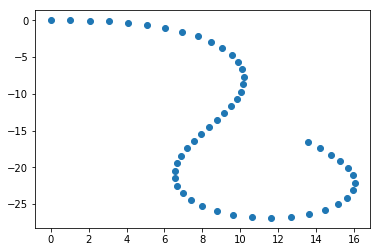

In [21]:
plt.scatter(x, y)
plt.show()